# Project 3 - Reddit Classification

## Problem Statement
Japanese and Chinese cuisines share many similarities. People from non-Asian backgrounds can easily mix them up. However, machine learning allows us to tell the two cuisines apart quickly. We aim to correctly sort Reddit posts into their related subreddits for this project using the classification model with the highest test score and the most balanced bias/variance tradeoff.  

### Imports

In [21]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics

### Data Collection

In [2]:
# Create a function to scrape data from reddit
def get_data(t, food):
    list_data = []
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {'subreddit': food, 'size': 100, 'before': t}
    data = requests.get(url, params).json()['data']
    list_data += data
    while len(list_data) <= 15_000: # Get up to 15_000 submissions
        new_t = list_data[-1].get('created_utc')
        new_params = {'subreddit': food, 'size': 100, 'before': new_t}
        new_data = requests.get(url, new_params).json()['data']
        list_data += new_data
        # introduce sleeptime to slowdown the pulling process. 
        # Since Reddit has limits to the maximum pulls per second. 
        time.sleep(1) 
    return pd.DataFrame(list_data)

In [3]:
df_jp = get_data(1639180013, 'JapaneseFood')

In [4]:
# Check the amount of posts we gathered
df_jp.shape

(15094, 100)

In [5]:
# Export gathered data as csv file
df_jp.to_csv('Data/Japanesefood.csv') 

In [6]:
# Create a function to scrape data from 'ChineseFood' subreddit.
# Same function used in JapaneseFood datacolletion. 
# With 9000 posts instead of 15_000 
# because 'ChineseFood' subreddit has less than 10_000 posts in total. 
def get_data(t, food):
    list_data = []
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {'subreddit': food, 'size': 100, 'before': t}
    data = requests.get(url, params).json()['data']
    list_data += data
    while len(list_data) <= 9_000: # Get up to 9_000 submissions. 
        new_t = list_data[-1].get('created_utc')
        new_params = {'subreddit': food, 'size': 100, 'before': new_t}
        new_data = requests.get(url, new_params).json()['data']
        list_data += new_data
        time.sleep(1)
    return pd.DataFrame(list_data)

In [7]:
# Use the function to gather data for subreddit 'ChineseFood';
df_ch = get_data(1639180013, 'ChineseFood')

In [8]:
# Check the amount of posts we gathered
df_ch.shape

(9096, 94)

In [9]:
# Export gathered data as csv file
df_ch.to_csv('Data/Chinesefood.csv') 

## Data Cleaning and EDA

In [10]:
# Merge Chinesefood and Japanesefood datasets
Chinesefood = pd.read_csv('Data/Chinesefood.csv')
Japanesefood = pd.read_csv('Data/Japanesefood.csv')
Chinesefood = Chinesefood[['subreddit', 'title']]
Japanesefood = Japanesefood[['subreddit', 'title']]

/Users/ben/opt/anaconda3/envs/dsi-111/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2,5,6,7,9,10,11,12,13,14,18,19,21,22,23,24,25,26,27,29,31,32,33,35,36,37,41,43,48,49,54,60,63,64,70,74,75,76,77,80,81,82,84,85,87,88) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/ben/opt/anaconda3/envs/dsi-111/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,9,13,14,20,21,22,23,24,25,27,28,30,31,34,35,36,42,49,50,51,69,72,73,80,85,87,88,90,91,92,93,99,100) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
# Check for missing values in the columns. 
food = pd.concat([Chinesefood, Japanesefood], ignore_index=True)
# Save and export combined datasets
food.to_csv('Data/food.csv', index=False)
food.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24190 entries, 0 to 24189
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  24190 non-null  object
 1   title      24190 non-null  object
dtypes: object(2)
memory usage: 378.1+ KB


In [12]:
# Drop duplicate rows
food.drop_duplicates(subset='title', inplace=True)

In [13]:
# Create a new column 'word_count'
food['word_count'] = food['title'].apply(lambda x: len(x.split()))

In [14]:
# Examine the summary statistics of the dataframe
food.describe()

,word_count
count,23336.000000
mean,9.214518
std,7.304929
min,1.000000
25%,5.000000
50%,7.000000
75%,11.000000
max,60.000000


In [15]:
food.subreddit.unique()

array(['chinesefood', 'JapaneseFood'], dtype=object)

In [16]:
# create two dataframes to examine word counts in each subreddits
chinesefood = food[food['subreddit'] == 'chinesefood']
japanesefood = food[food['subreddit'] == 'JapaneseFood']

In [17]:
# Summary statistic of chinesefood
chinesefood.describe()

,word_count
count,8841.000000
mean,9.512385
std,7.622105
min,1.000000
25%,5.000000
50%,8.000000
75%,11.000000
max,60.000000


In [18]:
# Summary statistic of japanesefood
japanesefood.describe()

,word_count
count,14495.000000
mean,9.032839
std,7.098658
min,1.000000
25%,5.000000
50%,7.000000
75%,11.000000
max,59.000000


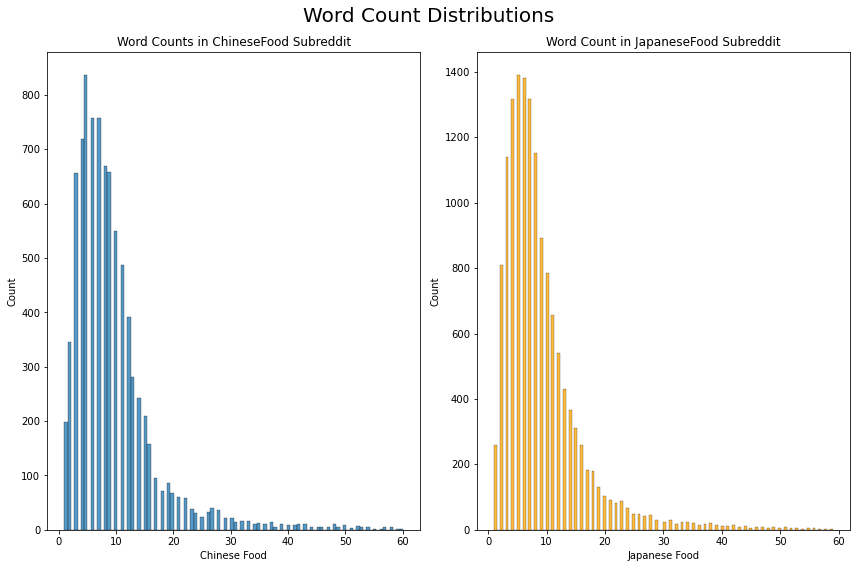

In [19]:
# Visualize the word counts of each subreddit
fig, ax = plt.subplots(1, 2, figsize=(12,8))
sns.histplot(chinesefood['word_count'], ax=ax[0])
sns.histplot(japanesefood['word_count'], ax=ax[1], color= 'orange' )
ax[0].set(xlabel="Chinese Food", ylabel='Count', title='Word Counts in ChineseFood Subreddit')
ax[1].set(xlabel="Japanese Food", ylabel='Count', title='Word Count in JapaneseFood Subreddit')

fig.suptitle('Word Count Distributions', fontsize=20);
plt.tight_layout()
plt.savefig("Figures/word_count_distributions.png")

## Preprocessing

In [22]:
tokenizer = RegexpTokenizer('\w+')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
import nltk
nltk.download('stopwords') #Download stopwords

[nltk_data] Downloading package stopwords to /Users/ben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
food = food.drop_duplicates(ignore_index=True)
food.head()

,subreddit,title,word_count
0,chinesefood,Cantonese Sausage Spare Ribs Claypot Rice,6
1,chinesefood,"Mapo Tofu, Tofu Mapo 麻婆豆腐！",5
2,chinesefood,Chinese hotpot ❤️,3
3,chinesefood,"Got our laoganma resupply in, plus some new st...",15
4,chinesefood,Xinjiang Roasted Nang,3


In [24]:
processed = []
for title in food['title']:
    # Tokenize the title
    tokens = tokenizer.tokenize(title.lower())
    # Remove stopwords
    no_stopwords = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize the tokens with stopwords removed
    lem_tokens = [lemmatizer.lemmatize(word) for word in no_stopwords]
    # Further stem the tokens
    stem_tokens = [stemmer.stem(word) for word in lem_tokens]
    joined_tokens = ' '.join(stem_tokens)
    processed.append(joined_tokens)

In [25]:
# Reassign processed title to a new column
food['tokens'] = pd.DataFrame(processed)

In [26]:
# Check for nulls
food.isnull().sum()

subreddit     0
title         0
word_count    0
tokens        0
dtype: int64

In [27]:
# Reassign values in the subreddit to binary 0/1's for classification
food['subreddit'] = food['subreddit'].map({'JapaneseFood': 0, 'chinesefood': 1}) 
# Save and export cleaned, tokenized, stemmed, stop_words removed data
food.to_csv('Data/cleaned_food.csv',index=False)

In [28]:
# Set X and y for modeling
X = food['tokens']
y = food['subreddit']

In [29]:
# Baseline Accuracy 
y.value_counts(normalize=True)

0    0.621143
1    0.378857
Name: subreddit, dtype: float64

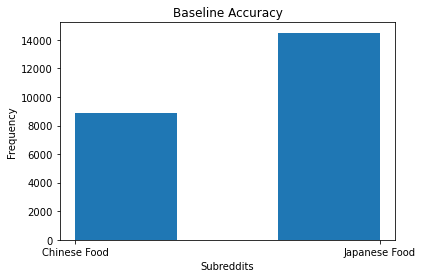

In [30]:
plt.hist(food['subreddit'].map({0:'Japanese Food', 1:'Chinese Food'}), bins=3)
plt.title('Baseline Accuracy')
plt.ylabel('Frequency')
plt.xlabel('Subreddits')
plt.tight_layout
plt.savefig("Figures/baseline.png")

In [31]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [32]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()
# Fit and transform cvec on X_train
X_train_cvec = cvec.fit_transform(X_train)
# Transform X_test
X_test_cvec = cvec.transform(X_test)

In [33]:
# Instantiate a TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [34]:
# Convert to matrix representation
X_train_cvec.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

## Model: Logistic Regression

In [36]:
# Logistic Regression
lr = LogisticRegressionCV(solver='liblinear')
lr.fit(X_train_cvec, y_train)
lr.score(X_train_cvec, y_train), lr.score(X_test_cvec, y_test)

(0.9730019284336833, 0.9089545844044559)

In [37]:
# Logistic Regression
lr_2 = LogisticRegressionCV(solver='liblinear')
lr_2.fit(X_train_tfidf, y_train)
lr_2.score(X_train_tfidf, y_train), lr.score(X_test_tfidf, y_test)

(0.9622884079708592, 0.8982433590402742)

## Model: Naive Bayes

In [38]:
# Instantiate Multinomial Naive Baye
nb = MultinomialNB()
nb.fit(X_train_cvec, y_train)
nb.score(X_train_cvec, y_train), nb.score(X_test_cvec, y_test)

(0.9438611527748018, 0.9108826049700086)

In [39]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb.score(X_train_tfidf, y_train), nb.score(X_test_tfidf, y_test)

(0.9300407113777587, 0.895458440445587)

In [40]:
# Instantiate Bernoulli Naive Baye
Bernoulli = BernoulliNB()
Bernoulli.fit(X_train_cvec, y_train)
Bernoulli.score(X_train_cvec, y_train), Bernoulli.score(X_test_cvec, y_test)

(0.9343796871652025, 0.9063838903170522)

In [41]:
Bernoulli = BernoulliNB()
Bernoulli.fit(X_train_tfidf, y_train)
Bernoulli.score(X_train_tfidf, y_train), Bernoulli.score(X_test_tfidf, y_test)

(0.9343796871652025, 0.9063838903170522)

## Modeling: Random Forest 

In [42]:
# Instantiate Random forest Classifier
rf= RandomForestClassifier()

In [43]:
cross_val_score(rf, X_train_cvec, y_train, cv=5).mean()

0.8834902764340281

In [44]:
# GridSearch over hyperparameters for Random Forest Classifier
rf_params = {
    'n_estimators': [100, 150, 200], # How many trees to build
    'max_depth': [None, 1, 2, 3], # Max input in each node. 
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv = 5, n_jobs = -1)
gs_rf.fit(X_train_cvec, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

0.8832761150674703


{'max_depth': None, 'n_estimators': 200}

In [45]:
# Evaluate the GridSearched RandomForest scores
gs_rf.score(X_train_cvec, y_train), gs_rf.score(X_test_cvec, y_test)

(0.9981787015213199, 0.8873179091688089)

# Evaluations

In [46]:
# Make a separate dataframe for chinesefood
c_chinesefood = food.loc[(food['subreddit']==1)]
c_tokens = c_chinesefood['tokens']

In [47]:
# CountVectorize to tokenize the title
cv_chinese = CountVectorizer()
ch_vect = cv_chinese.fit_transform(c_tokens)
ch_vect_df = pd.DataFrame(ch_vect.todense(), columns=cv_chinese.get_feature_names())
ch_vect_df.head()

,000,007,08,083,10,100,1000,10000,101,1020,...,𝐟𝐫𝐲,𝗕𝗥𝗔𝗜𝗦𝗘𝗗,𝗕𝗨𝗗𝗦,𝗖𝗛𝗜𝗖𝗞𝗘𝗡,𝗘𝗔𝗥,𝗟𝗜𝗟𝗬,𝗠𝗨𝗦𝗛𝗥𝗢𝗢𝗠𝗦,𝗦𝗛𝗜𝗜𝗧𝗔𝗞𝗘,𝗪𝗜𝗧𝗛,𝗪𝗢𝗢𝗗
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Make a separate dataframe for Japanesefood
c_japanesefood = food.loc[(food['subreddit']==0)]
j_tokens = c_japanesefood['tokens']

In [49]:
# CountVectorize to tokenize the title
cv_jap = CountVectorizer()
jap_vect = cv_jap.fit_transform(j_tokens)
jap_vect_df = pd.DataFrame(jap_vect.todense(), columns=cv_jap.get_feature_names())
jap_vect_df.head()

,00,000,0032,0044,0064,00pm,01,017,02,020,...,𝗪𝗵𝗮𝘁,𝗮𝗻𝗱,𝗳𝗼𝗼𝗱,𝗶𝗻,𝗶𝘀,𝗺𝗼𝘀𝘁,𝗼𝘃𝗲𝗿,𝗼𝘃𝗲𝗿𝗿𝗮𝘁𝗲𝗱,𝗽𝗿𝗮𝗶𝘀𝗲𝗱,𝘁𝗵𝗲
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


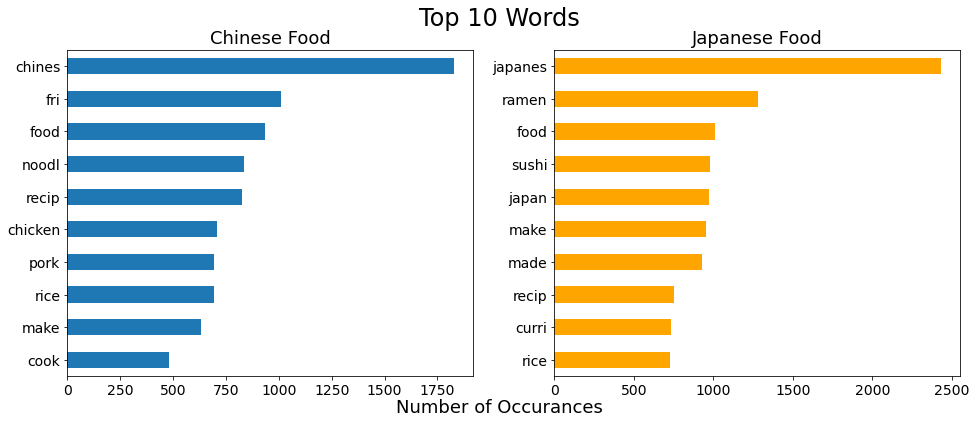

In [50]:
# Plot to visualize the top 10 occuring words in each subreddit
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ch_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
jap_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14, color='orange')

ax[1].set_title('Japanese Food', fontsize=18)
ax[0].set_title('Chinese Food', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', 
         ha='center', fontsize=18);

plt.savefig("Figures/top_10_words.png")

In [51]:
# Evaluate different model performances
print(' ======Logistic Regression======')
print(f'Count Vectorizer Training Score: {lr.score(X_train_cvec, y_train)}')
print(f'Count Vectorizer Testing Score: {lr.score(X_test_cvec, y_test)}')
print(f'Difference: {lr.score(X_train_cvec, y_train) - lr.score(X_test_cvec, y_test)}')
print()
print(f'Tfidf Vectorizer Training Score: {lr_2.score(X_train_tfidf, y_train)}') 
print(f'Tfidf Vectorizer Testing Score: {lr_2.score(X_test_tfidf, y_test)}')
print(f'Difference: {lr_2.score(X_train_tfidf, y_train) - lr_2.score(X_test_tfidf, y_test)}')
print()
print(' ======Multinomial Naive Bayes======')
print(f'Count Vectorizer Training Score: {nb.score(X_train_cvec, y_train)}'), 
print(f'Count Vectorizer Testing Score: {nb.score(X_test_cvec, y_test)}'),
print(f'Difference: {nb.score(X_train_cvec, y_train)-nb.score(X_test_cvec, y_test)}')
print()
print(f'Tfidf Vectorizer Training Score: {nb.score(X_train_tfidf, y_train)}') 
print(f'Tfidf Vectorizer Testing Score: {nb.score(X_test_tfidf, y_test)}')
print(f'Difference: {nb.score(X_train_tfidf, y_train) - nb.score(X_test_tfidf, y_test)}')
print()
print(' ======Bernoulli Naive Bayes======')
print(f'Count Vectorizer Training Score: {Bernoulli.score(X_train_cvec, y_train)}')
print(f'Count Vectorizer Testing Score: {Bernoulli.score(X_test_cvec, y_test)}')
print(f'Difference: {Bernoulli.score(X_train_cvec, y_train)-Bernoulli.score(X_test_cvec, y_test)}')
print()
print(f'Tfidf Vectorizer Training Score: {Bernoulli.score(X_train_tfidf, y_train)}')
print(f'Tfidf Vectorizer Testing Score: {Bernoulli.score(X_test_tfidf, y_test)}')
print(f'Difference: {Bernoulli.score(X_train_tfidf, y_train) - Bernoulli.score(X_test_tfidf, y_test)}')
print()
print(' ======Random Forest Classifier======')
print(f'Count Vectorizer GS Training Score: {gs_rf.score(X_train_cvec, y_train)}')
print(f'Count Vectorizer GS Testing Score: {gs_rf.score(X_test_cvec, y_test)}')
print(f'Difference: {gs_rf.score(X_train_cvec, y_train)-gs_rf.score(X_test_cvec, y_test)}')

 ======Logistic Regression======
Count Vectorizer Training Score: 0.9730019284336833
Count Vectorizer Testing Score: 0.9089545844044559
Difference: 0.0640473440292274

Tfidf Vectorizer Training Score: 0.9622884079708592
Tfidf Vectorizer Testing Score: 0.910025706940874
Difference: 0.052262701029985204

 ======Multinomial Naive Bayes======
Count Vectorizer Training Score: 0.9358795800299978
Count Vectorizer Testing Score: 0.9068123393316195
Difference: 0.029067240698378294

Tfidf Vectorizer Training Score: 0.9300407113777587
Tfidf Vectorizer Testing Score: 0.895458440445587
Difference: 0.0345822709321717

 ======Bernoulli Naive Bayes======
Count Vectorizer Training Score: 0.9343796871652025
Count Vectorizer Testing Score: 0.9063838903170522
Difference: 0.027995796848150234

Tfidf Vectorizer Training Score: 0.9343796871652025
Tfidf Vectorizer Testing Score: 0.9063838903170522
Difference: 0.027995796848150234

 ======Random Forest Classifier======
Count Vectorizer GS Training Score: 0.998

# Model selection & Prediction
- Multinomial and Bernoulli naive bayes perform very similarly on the testing scores. However, the Bernoulli naive baye has a slightly lower difference between training and testing scores, suggesting more balanced bias/variances trade-ff and less overfit. 
- No significant differences between the choice of count vectorizers were examined.
- Random forest classifier is not a good model for this project for a couple of reasons. 
    - The model is highly overfitting and has lower testing scores than all the other models.
    - Random forest classifiers do not work well with unbalanced datasets, which in our case, the number of posts in 'JapaneseFood' and 'ChineseFood' is not balanced. The unbalance will bias the result of the trees toward the majority class, which is the 'JapaneseFood' subreddit. 

In [52]:
predictions = Bernoulli.predict(X_test_cvec)

In [53]:
# Create a confusion matrix
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

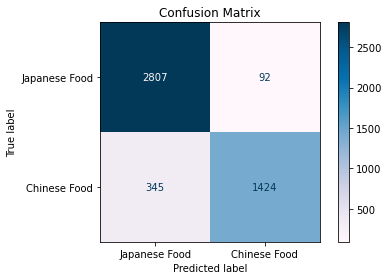

In [54]:
# Visualize confusion matrix
metrics.plot_confusion_matrix(Bernoulli, X_test_cvec, y_test, display_labels= ['Japanese Food', 'Chinese Food'], cmap='PuBu');
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('Figures/confusion_matrix.png')

In [55]:
# F1 score of the confusion matrix
metrics.f1_score(y_test, predictions)

0.8669710806697108

In [56]:
print('Model Performance')
print(f'Accuracy: {(tn + tp)/(tn+fp+fn+tp)}')
print(f'Precision: {(tp)/(fp+tp)}')
print(f'Sensitivity & Type II Error: {(tp)/(tp+fn)}')
print(f'Specificity & Type I Error: {(tn)/(tn+fp)}')

Model Performance
Accuracy: 0.9063838903170522
Precision: 0.9393139841688655
Sensitivity & Type II Error: 0.8049745618993782
Specificity & Type I Error: 0.9682649189375647


## Conclusions:
- The classification model we have created is a Bernoulli Naive Baye Classifier using CountVectorizer as the transformer. It has a training score of 0.9343796871652025, a testing score of 0.9063838903170522, and the difference between the two scores is 0.027995796848150234.
- The model has 90.6% accuracy on unseen data and balanced bias/variances tradeoff. 
- we expect the model to have better performances with a larger and more evenly distributed dataset.  The dataset used in this project was not evenly distributed because ChineseFood subreddit had fewer than 10_000 total posts by the time we created the model. Thus, we also had to limit the number of datasets for the JapaneseFood subreddit to limit the bias towards the majority class. 
- In conclusion, machine learning allows us to create a model using CountVectorizer and Bernoulli Naive Baye Classifier to distinguish and separate posts into their corresponding Reddits with 90% accuracy. This model can be applied to sort other subreddits, and we expect the accuracy to be higher on subreddits with more distinct characteristics. 